In [1]:
#imports

import os
import email
import numpy as np
import pandas as pd
import seaborn as sns
import multiprocessing
import matplotlib.pyplot as plt

In [2]:
#read in dataset
#Note: explanations for steps are in the google doc. It was easier to write paragraphs in there rather than comments in here. Preprocessing code adapted from: https://www.kaggle.com/ankurrezo/data-cleaning-and-transformation-enron-email


df = pd.read_csv('C:/Users/benso/Desktop/Projects/UsableAI/Project/emails.csv')
print(df.shape)
df.head()
print(df.head())

(517401, 2)
                       file                                            message
0     allen-p/_sent_mail/1.  Message-ID: <18782981.1075855378110.JavaMail.e...
1    allen-p/_sent_mail/10.  Message-ID: <15464986.1075855378456.JavaMail.e...
2   allen-p/_sent_mail/100.  Message-ID: <24216240.1075855687451.JavaMail.e...
3  allen-p/_sent_mail/1000.  Message-ID: <13505866.1075863688222.JavaMail.e...
4  allen-p/_sent_mail/1001.  Message-ID: <30922949.1075863688243.JavaMail.e...


In [71]:
#The dataset is too big to be running this initial analysis locally. I'm going to do some sampling for this initial analysis, and then when it comes time to run the ML pipelines, I'll run things on the cluster.

import random
import pandas as pd 
filename = 'C:/Users/benso/Desktop/Projects/UsableAI/Project/emails.csv'
n = sum(1 for line in open(filename)) - 1 #number of records in file (excludes header)
s = 20000 #desired sample size
skip = sorted(random.sample(range(1,n+1),n-s)) #the 0-indexed header will not be included in the skip list
df = pd.read_csv(filename, skiprows=skip)
print(df.head())

                          file  \
0      allen-p/_sent_mail/209.   
1   allen-p/all_documents/158.   
2   allen-p/deleted_items/141.   
3  arnold-j/all_documents/810.   
4       bass-e/_sent_mail/920.   

                                             message  
0  Message-ID: <29850337.1075855689832.JavaMail.e...  
1  Message-ID: <15943342.1075855668962.JavaMail.e...  
2  Message-ID: <441422.1075858633856.JavaMail.eva...  
3  Message-ID: <13542936.1075857608613.JavaMail.e...  
4  Message-ID: <9703674.1075854728683.JavaMail.ev...  


In [3]:
message = df.loc[1]['message']
e = email.message_from_string(message)

e.items()

[('Message-ID', '<15464986.1075855378456.JavaMail.evans@thyme>'),
 ('Date', 'Fri, 4 May 2001 13:51:00 -0700 (PDT)'),
 ('From', 'phillip.allen@enron.com'),
 ('To', 'john.lavorato@enron.com'),
 ('Subject', 'Re:'),
 ('Mime-Version', '1.0'),
 ('Content-Type', 'text/plain; charset=us-ascii'),
 ('Content-Transfer-Encoding', '7bit'),
 ('X-From', 'Phillip K Allen'),
 ('X-To', 'John J Lavorato <John J Lavorato/ENRON@enronXgate@ENRON>'),
 ('X-cc', ''),
 ('X-bcc', ''),
 ('X-Folder', "\\Phillip_Allen_Jan2002_1\\Allen, Phillip K.\\'Sent Mail"),
 ('X-Origin', 'Allen-P'),
 ('X-FileName', 'pallen (Non-Privileged).pst')]

In [4]:
# now we add those fields into our 'df' dataframe
def get_field(field, messages):
    column = []
    for message in messages:
        e = email.message_from_string(message)
        column.append(e.get(field))
    return column

In [5]:
df['date'] = get_field("Date", df['message'])
df['subject'] = get_field("Subject", df['message'])
df['X-Folder'] = get_field("X-Folder", df['message'])
df['X-From'] = get_field("X-From", df['message'])
df['X-To'] = get_field("X-To", df['message'])
df.head()

,file,message,date,subject,X-Folder,X-From,X-To
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",Re:,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",Re: test,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Phillip K Allen,Leah Van Arsdall
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Phillip K Allen,Randall L Gay
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",Re: Hello,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Phillip K Allen,Greg Piper


In [6]:
def body(messages):
    column = []
    for message in messages:
        e = email.message_from_string(message)
        column.append(e.get_payload())
    return column

df['body'] = body(df['message'])
df.head(3)

,file,message,date,subject,X-Folder,X-From,X-To,body
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,Here is our forecast\n\n
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",Re:,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,Traveling to have a business meeting takes the...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",Re: test,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Phillip K Allen,Leah Van Arsdall,test successful. way to go!!!


In [7]:
df['file'][:10]

0       allen-p/_sent_mail/1.
1      allen-p/_sent_mail/10.
2     allen-p/_sent_mail/100.
3    allen-p/_sent_mail/1000.
4    allen-p/_sent_mail/1001.
5    allen-p/_sent_mail/1002.
6    allen-p/_sent_mail/1003.
7    allen-p/_sent_mail/1004.
8     allen-p/_sent_mail/101.
9     allen-p/_sent_mail/102.
Name: file, dtype: object

In [8]:
def employee(file):
    column = []
    for string in file:
        column.append(string.split("/")[0])
    return column

df['employee'] = employee(df['file'])
df.head(3)

,file,message,date,subject,X-Folder,X-From,X-To,body,employee
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,Here is our forecast\n\n,allen-p
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",Re:,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,Traveling to have a business meeting takes the...,allen-p
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",Re: test,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Phillip K Allen,Leah Van Arsdall,test successful. way to go!!!,allen-p


In [9]:
top_20 = pd.DataFrame(df['employee'].value_counts()[:20])
top_20.reset_index(inplace=True)
top_20.columns = ["Employee_name", "Counts"]
top_20

,Employee_name,Counts
0,kaminski-v,28465
1,dasovich-j,28234
2,kean-s,25351
3,mann-k,23381
4,jones-t,19950
5,shackleton-s,18687
6,taylor-m,13875
7,farmer-d,13032
8,germany-c,12436
9,beck-s,11830


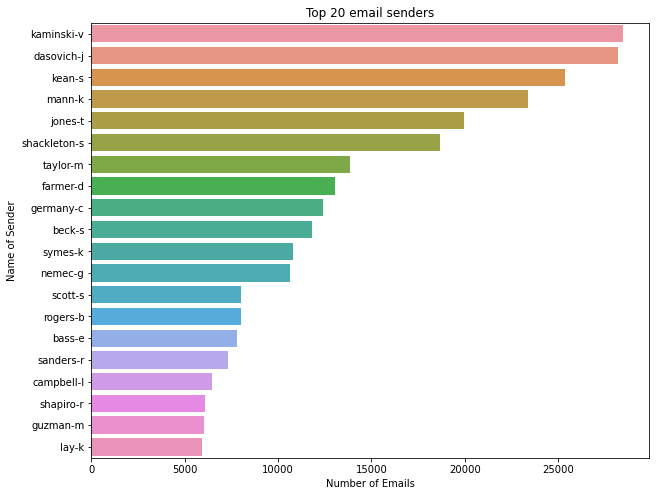

In [11]:
#Let's look at the top 20 email senders.

plt.figure(figsize=(10,8))

sns.barplot(y="Employee_name", x="Counts", data=top_20)
plt.title("Top 20 email senders")
plt.xlabel("Number of Emails")
plt.ylabel("Name of Sender")
#plt.savefig('C:/Users/benso/Desktop/Projects/UsableAI/Project/Figures/top20senders.png')
plt.show()

In [12]:
#Let's parse out what the subject of these emails are, or the folders that they're in.

print("number of folders: ", df.shape[0])
print("number of unique folders: ", df['X-Folder'].unique().shape[0])

number of folders:  517401
number of unique folders:  5336


In [13]:
unique_emails = pd.DataFrame(df['X-Folder'].value_counts())
unique_emails.reset_index(inplace=True)


unique_emails.columns = ['folder_name', 'count']
# top 20 folders
unique_emails.iloc[:20,:]

,folder_name,count
0,\Kay_Mann_June2001_1\Notes Folders\All documents,6639
1,\Tanya_Jones_Dec2000\Notes Folders\All documents,5934
2,\Jeff_Dasovich_June2001\Notes Folders\All docu...,5637
3,\Sara_Shackleton_Dec2000_June2001_1\Notes Fold...,5211
4,\Vincent_Kaminski_Jun2001_1\Notes Folders\All ...,5066
5,\Kay_Mann_June2001_2\Notes Folders\Discussion ...,4956
6,\Jeff_Dasovich_Dec2000\Notes Folders\All docum...,4660
7,\Kay_Mann_June2001_3\Notes Folders\Sent,4440
8,\Kay_Mann_June2001_4\Notes Folders\'sent mail,4220
9,\Mark_Taylor _Dec_2000\Notes Folders\All docum...,4022


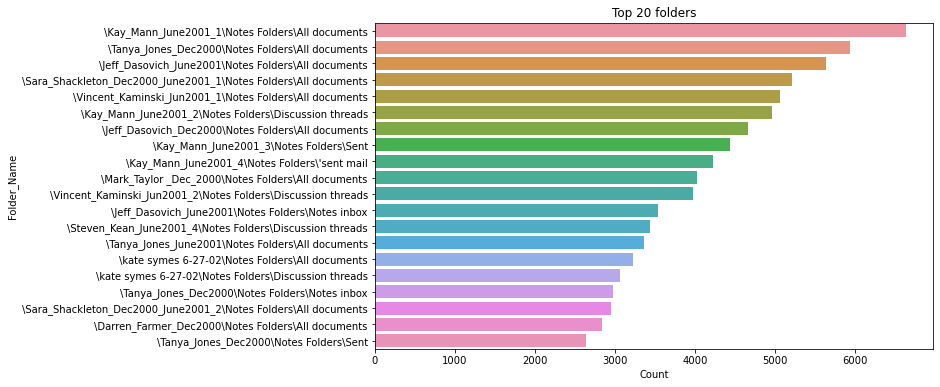

In [14]:
plt.figure(figsize=(10,6))
sns.barplot(x='count', y='folder_name', data=unique_emails.iloc[:20, :])
plt.title("Top 20 folders")
plt.xlabel("Count")
plt.ylabel("Folder_Name")
plt.show()

In [15]:
#Let's make the column names more readable


print(df['X-Folder'][0])

# we only want last folder name
df['X-Folder'][0].split("\\")[-1]

\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail


"'Sent Mail"

In [16]:
#we only care about particular parts of the folder text

def preprocess_folder(folders):
    column = []
    for folder in folders:
        if (folder is None or folder == ""):
            column.append(np.nan)
        else:
            column.append(folder.split("\\")[-1].lower())
    return column

df['X-Folder'] = preprocess_folder(df['X-Folder'])
df.head(2)

,file,message,date,subject,X-Folder,X-From,X-To,body,employee
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",,'sent mail,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,Here is our forecast\n\n,allen-p
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",Re:,'sent mail,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,Traveling to have a business meeting takes the...,allen-p


In [17]:
# count unique folders
print("Unique Folders: ", len(df['X-Folder'].unique()))

# view some of them
df['X-Folder'].unique()[0:20]

Unique Folders:  1782


array(["'sent mail", 'all documents', 'contacts', 'deleted items',
       'discussion threads', 'inbox', 'notes inbox', 'sent items', 'sent',
       'straw', '2000 conference', 'active international', 'avaya', 'bmc',
       'bridge', 'bristol babcock', 'colleen koenig', 'compaq',
       'computer associates', 'continental airlines'], dtype=object)

In [18]:
#get rid of empty values, replace with 'nan'. This is important because sometimes, if an email is a reply or a forward, there might not be a separate 'subject' field.

def replace_empty_with_nan(subject):
    column = []
    for val in subject:
        if (val == ""):
            column.append(np.nan) 
        else:
            column.append(val)
    return column

In [27]:
df['subject'] = replace_empty_with_nan(df['subject'])
df['X-To'] = replace_empty_with_nan(df['X-To'])

In [28]:
# calculate percentage of missing values
miss = df.isnull().sum()
miss = miss[miss>0]
miss = miss / df.shape[0]
miss

X-To    0.017965
dtype: float64

In [29]:
df.dropna(axis=0, inplace=True)

In [30]:
df.isnull().sum(), df.shape

(file        0
 message     0
 date        0
 subject     0
 X-Folder    0
 X-From      0
 X-To        0
 body        0
 employee    0
 dtype: int64,
 (489236, 9))

In [31]:
df.head(3)


,file,message,date,subject,X-Folder,X-From,X-To,body,employee
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",Re:,'sent mail,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,Traveling to have a business meeting takes the...,allen-p
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",Re: test,'sent mail,Phillip K Allen,Leah Van Arsdall,test successful. way to go!!!,allen-p
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",Re: Hello,'sent mail,Phillip K Allen,Greg Piper,Let's shoot for Tuesday at 11:45.,allen-p


In [25]:
cols_to_drop = ['X-To']
df.drop(cols_to_drop, axis=1, inplace=True)


KeyError: "['To'] not found in axis"

In [136]:
df.head()

,subject,X-Folder,X-From,X-To,employee,body
0,Re: your address,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Phillip K Allen,"""Hargrove, Mac D"" <mac.d.hargrove@rssmb.com> @...",allen-p,the merlin ct. address is still good. I don't...
1,Re: (No Subject),\Phillip_Allen_Dec2000\Notes Folders\All docum...,Phillip K Allen,muller@thedoghousemail.com,allen-p,"Greg,\n\n Got your message. Good luck on the ..."
2,Work Hours,"\PALLEN (Non-Privileged)\Allen, Phillip K.\Del...","Grigsby, Mike </O=ENRON/OU=NA/CN=RECIPIENTS/CN...","Allen, Phillip K. </O=ENRON/OU=NA/CN=RECIPIENT...",allen-p,"Dear West,\n\nWe talked briefly on Monday abou..."
3,Re: Cancellation of EOL Deal #1025253,\John_Arnold_Jun2001\Notes Folders\All documents,John Arnold,herve.duteil@americas.bnpparibas.com @ ENRON,arnold-j,confirm\n\n\n\n\nherve.duteil@americas.bnppari...
4,Re: Vandy,\Eric_Bass_Dec2000\Notes Folders\'sent mail,Eric Bass,Timothy Blanchard,bass-e,BRUTAL!\n\n\n \n\tEnron North America Corp.\...


In [32]:
sendees = pd.DataFrame(df['X-To'].value_counts())
sendees.reset_index(inplace=True)


sendees.columns = ['Sendees', 'count']
# top 20 folders
sendees.iloc[:20,:]

,Sendees,count
0,pete.davis@enron.com,5334
1,Tana Jones,4037
2,"Davis, Pete </O=ENRON/OU=NA/CN=RECIPIENTS/CN=P...",3798
3,vkaminski@aol.com,3695
4,All Enron Worldwide,3243
5,Kate Symes,3089
6,Sara Shackleton,2887
7,Steven J Kean,2831
8,Mark Taylor,2438
9,Jeff Dasovich,2404


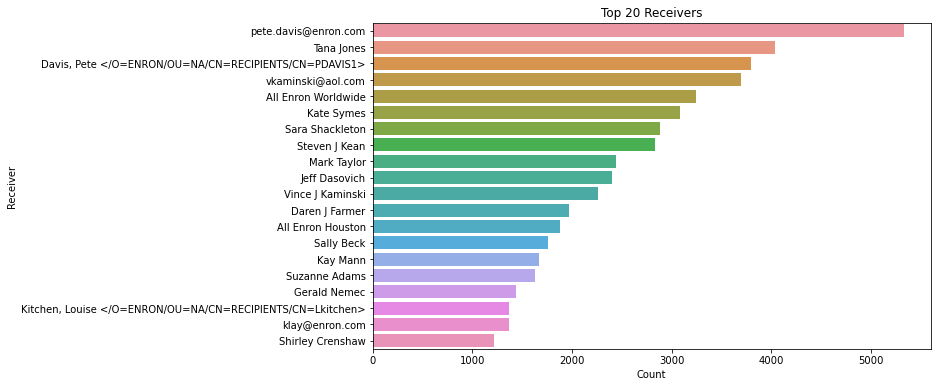

In [33]:
#not sure if this is important, but we can look at the top 20 people to receive emails, rather than who sent them.

plt.figure(figsize=(10,6))
sns.barplot(x='count', y='Sendees', data=sendees.iloc[:20, :])
plt.title("Top 20 Receivers")
plt.xlabel("Count")
plt.ylabel("Receiver")
plt.show()

In [34]:
df.to_csv('cleaned_enron.csv')

In [36]:
import datetime
from dateutil import parser
def change_type(dates):
    column = []
    
    for date in dates:
        column.append(parser.parse(date).strftime("%d-%m-%Y %H:%M:%S"))
    return column

df['date'] = change_type(df['date'])
df.head(2)

,file,message,date,subject,X-Folder,X-From,X-To,body,employee
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,04-05-2001 13:51:00,Re:,'sent mail,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,Traveling to have a business meeting takes the...,allen-p
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,18-10-2000 03:00:00,Re: test,'sent mail,Phillip K Allen,Leah Van Arsdall,test successful. way to go!!!,allen-p


In [37]:
df.to_csv('cleaned_enron.csv')